# About

Let's play a bit with Legal Document Retrieval and some datasets.

- https://github.com/lavis-nlp/GerDaLIR

In [79]:
import pandas as pd
import torch, torch.nn.functional as F
import numpy as np
import gc
import os
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import seaborn as sns
import spacy
import spacy.cli

from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from io import StringIO
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer

#from cuml.svm import SVR as cumlSVR
#from cuml.preprocessing import StandardScaler as cumlStandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/tmp/ipykernel_781799/3679018477.py:18: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [80]:
pd.set_option('display.max_colwidth', None)  # None means unlimited width

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(device)
print(available_gpus)

cuda
[<torch.cuda.device object at 0x7fd2303c5ae0>, <torch.cuda.device object at 0x7fd2303c5300>]


In [81]:
class Config:
    GERDALIR_PATH = './data/GerDaLIR/'
    EMBEDDINGS_DIRECTORY = './data/embeddings/'
    REMOVE_STOPWORDS = False
    EXLODE_SENTENCES = True
    USE_TFIDF = False
    TRAIN_SVR = False

# Load Data

In [82]:
def read_tsv(file_path):
    data = []
    with open(file_path, 'r', encoding='utf8') as file:
        for line in file:
            columns = line.strip().split('\t')
            # Concatenate columns from index 1 onwards (since we have some broken rows)
            concatenated_value = ''.join(columns[1:])
            data.append((columns[0], concatenated_value))

    df = pd.DataFrame(data, columns=['id', 'value'])
    return df

In [83]:
collection = read_tsv(Config.GERDALIR_PATH + 'collection/collection.tsv').head(10000)
collection.rename(columns={'id': 'd_id', 'value':'passage'}, inplace=True)
collection.reset_index(inplace=True)

rels = read_tsv(Config.GERDALIR_PATH + 'qrels/qrels.dev.tsv')
rels.rename(columns={'id': 'q_id', 'value': 'd_id'}, inplace=True)
rels = rels[rels['d_id'].isin(collection['d_id'].values)] # This can be deleted once we work with all
rels.reset_index(inplace=True)

queries = read_tsv(Config.GERDALIR_PATH + 'queries/queries.dev.tsv')
queries.rename(columns={'id': 'q_id', 'value': 'query'}, inplace=True)
queries = queries[queries['q_id'].isin(rels['q_id'].values)] # This can be deleted once we work with all
queries.reset_index(inplace=True)


In [84]:
display(queries.head(2))
display(len(queries))

display(collection.head(2))
display(len(collection))

display(rels.head(2))
display(len(rels))

index  q_id  \
0      0     8   
1    113  1265   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           query  
0                                                                             Einen Verstoß gegen das Zitiergebot begründet zunächst nicht die Angabe fehlerhafter oder überflüssiger Vorschriften, da der Sinn und Zweck des [REF] ebenfalls erreicht wird, wenn die zutreffenden Vorschriften zumindest benannt werden . Die fehlerhafte Zitierung darf allerdings nicht irreführend für den Normadressaten sein . Fehlerhaft ist insoweit die Benennung von [REF] in der Ursprungssatzung vom [DATE] , in der 0. Nachtragssatzung von [DATE] und der 0. Nachtragssatzung von [DATE] . Während [REF] in der Fassung vom [DATE] die Beseitigung von Niederschlagswasser regelt, ist [REF] in der Fassung vom [DATE] gestrichen worden und [REF] [DATE] für das Amt nicht heranzuziehen. Zudem ergibt sich die grundsätzliche Abwasserbeseitigungspflicht hinsichtlich der 0. Nachtragssatzung vom [DATE] nicht aus [REF] [DATE] , sondern [REF] [DATE] . Zutreffend ist lediglich die Nennung von [REF] [DATE] und [DATE] . Hierdurch werden aber nicht alle zutreffenden Vorschriften benannt.  
1  Ergänzend verwies der Prozessbevollmächtigte der Antragsteller auf seinen Vortrag in einem zu einem vergleichbaren Sachverhalt geführten Beschwerdeverfahren vor dem Niedersächsischen Oberverwaltungsgericht . Es sei bei Erlass der Befreiungsregelung für Risikopatienten auch im Kultusministerium davon ausgegangen worden, dass die konkrete Möglichkeit der Entwicklung von Infektionsgeschehen an Schulen bestehe und aus diesem Grunde Schüler und Lehrer, welche einer Risikogruppe angehören, präventiv zu schützen seien. In Bezug auf Schüler mit Angehörigen aus einer Risikogruppe werde hingegen der staatlichen Verpflichtung aus [REF] durch die derzeitigen Regelungen nicht in ausreichender Weise nachgekommen. Auch werde dem Grundrecht auf „Schutz der Familie“ aus [REF] nicht ausreichend genüge getan. Die Familien würden vor die Wahl gestellt, entweder den betreffenden Angehörigen in einer nicht zumutbaren Weise einem Infektionsrisiko auszusetzen oder aber zum Schutze der vulnerablen Angehörigen einzelne Familienmitglieder voneinander zu isolieren.

4

index d_id  \
0      0    1   
1      1    1   

                                                                                                                                                                                                                                                                                                                                          passage  
0                                                         Tenor Der Antrag der Klägerin auf Zulassung der Berufung gegen das Urteil des Verwaltungsgerichts Gelsenkirchen vom [DATE] wird abgelehnt. Die Klägerin trägt die Kosten des Zulassungsverfahrens. Der Streitwert wird auch für das Zulassungsverfahren auf 0 Euro festgesetzt. Gründe:  
1  Das Zulassungsvorbringen der Klägerin begründet keine ernstlichen Zweifel an der Richtigkeit des angefochtenen Urteils . Zweifel in diesem Sinn sind anzunehmen, wenn ein einzelner tragender Rechtssatz oder eine einzelne erhebliche Tatsachenfeststellung des Verwaltungsgerichts mit schlüssigen Gegenargumenten in Frage gestellt werden.

10000

index  q_id d_id
0      0     8  301
1    126  1265   33

4

In [85]:
print(queries[queries['q_id'] == rels.iloc[0]['q_id']])
print(collection[collection['d_id'] == rels.iloc[0]['d_id']])

   index q_id  \
0      0    8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

# Preprocess Data

### Stopwords

In [86]:
nltk.download('stopwords')
nltk.download('punkt')

german_stop_words = stopwords.words('german')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/staff_homes/kboenisc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff_homes/kboenisc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Remove typical stopwords and also those [REF] and [DATE] terms.

In [87]:
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered = [word for word in words if word.lower() not in german_stop_words]
    return ' '.join(filtered).replace('[REF]', '').replace('[DATE]', '').replace('[ REF ]', '').replace('[ DATE ]', '')

In [88]:
print(remove_stopwords("Dies ist ein Test um zu schauen ob die Stoppwörter auch wirklich gelöscht werden."))

Test schauen Stoppwörter wirklich gelöscht .


In [89]:
if(Config.REMOVE_STOPWORDS):
    collection['passage'] = collection['passage'].apply(lambda x: remove_stopwords(x))
    queries['query'] = queries['query'].apply(lambda x: remove_stopwords(x))
    
    display(collection.head(2))
    display(queries.head(2))

### TF-IDF Frequency

In [90]:
if(Config.USE_TFIDF):
    corpus = collection['passage'].tolist()
    # Apply TF-IDF
    vectorizer = TfidfVectorizer(stop_words=german_stop_words)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Get the top keywords for the whole corpus
    def get_top_keywords(vectorizer, X, top_n=10):
        # Sum the TF-IDF scores for each term across all documents
        sums = X.sum(axis=0)
        # Get the indices of the top_n terms
        indices = sums.argsort()[0, ::-1][:top_n].tolist()[0]
        return [feature_names[i] for i in indices][top_n:]
    
    top_keywords = get_top_keywords(vectorizer, X, top_n=500)
    print(top_keywords)

    # Function to truncate text based on top keywords
    def truncate_text(text, top_keywords, max_length=32):
        words = word_tokenize(text.lower())
        truncated_words = [word for word in words if word in top_keywords]
        if len(truncated_words) > max_length:
            truncated_words = truncated_words[:max_length]
        return ' '.join(truncated_words)
    
    collection['passage'] = collection['passage'].apply(lambda x: truncate_text(x, top_keywords, max_length=32))
    queries['query'] = queries['query'].apply(lambda x: truncate_text(x, top_keywords, max_length=32))    

    display(collection.head())
    display(queries.head())

### Sentence Explosion

In [91]:
spacy.cli.download("de_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 32.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [92]:
nlp = spacy.load("de_core_news_sm")

In [93]:
def extract_sentences(text):
    return [sent.text for sent in nlp(text).sents]

In [94]:
if(Config.EXLODE_SENTENCES):
    collection['passage'] = collection['passage'].apply(extract_sentences)
    collection = collection.explode('passage').reset_index(drop=True)
    
    queries['query'] = queries['query'].apply(extract_sentences)
    queries = queries.explode('query').reset_index(drop=True)
    display(collection.head(10))
    display(queries.head(10))


index d_id  \
0      0    1   
1      0    1   
2      0    1   
3      0    1   
4      0    1   
5      0    1   
6      1    1   
7      1    1   
8      2    1   
9      2    1   

                                                                                                                                                                                                                                                                                                                                                                                                                                          passage  
0                                                                                                                                                                                                                                                                                                                                                                                                                                           Tenor  
1                                                                                                                                                                                                                                                                                                                             Der Antrag der Klägerin auf Zulassung der Berufung gegen das Urteil des Verwaltungsgerichts Gelsenkirchen vom [DATE  
2                                                                                                                                                                                                                                                                                                                                                                                                                               ] wird abgelehnt.  
3                                                                                                                                                                                                                                                                                                                                                                                         Die Klägerin trägt die Kosten des Zulassungsverfahrens.  
4                                                                                                                                                                                                                                                                                                                                                                    Der Streitwert wird auch für das Zulassungsverfahren auf 0 Euro festgesetzt.  
5                                                                                                                                                                                                                                                                                                                                                                                                                                         Gründe:  
6                                                                                                                                                                                                                                                                                                                        Das Zulassungsvorbringen der Klägerin begründet keine ernstlichen Zweifel an der Richtigkeit des angefochtenen Urteils .  
7                                                                                                                                                                                                                           Zweifel in diesem Sinn sind anzunehmen, wenn ein einzelner tragender Rechtssatz oder eine einzelne erheblic

index  q_id  \
0      0     8   
1      0     8   
2      0     8   
3      0     8   
4      0     8   
5      0     8   
6      0     8   
7      0     8   
8    113  1265   
9    113  1265   

                                                                                                                                                                                                                                                                                                                   query  
0                                                                           Einen Verstoß gegen das Zitiergebot begründet zunächst nicht die Angabe fehlerhafter oder überflüssiger Vorschriften, da der Sinn und Zweck des [REF] ebenfalls erreicht wird, wenn die zutreffenden Vorschriften zumindest benannt werden .  
1                                                                                                                                                                                                                              Die fehlerhafte Zitierung darf allerdings nicht irreführend für den Normadressaten sein .  
2                                                                                                                                                           Fehlerhaft ist insoweit die Benennung von [REF] in der Ursprungssatzung vom [DATE] , in der 0. Nachtragssatzung von [DATE] und der 0. Nachtragssatzung von [  
3                                                                                                                                                                                                                                                                                                                DATE] .  
4                                                                                                                        Während [REF] in der Fassung vom [DATE] die Beseitigung von Niederschlagswasser regelt, ist [REF] in der Fassung vom [DATE] gestrichen worden und [REF] [DATE] für das Amt nicht heranzuziehen.  
5                                                                                                                                                       Zudem ergibt sich die grundsätzliche Abwasserbeseitigungspflicht hinsichtlich der 0. Nachtragssatzung vom [DATE] nicht aus [REF] [DATE] , sondern [REF] [DATE] .  
6                                                                                                                                                                                                                                                     Zutreffend ist lediglich die Nennung von [REF] [DATE] und [DATE] .  
7                                                                                                                                                                                                                                                    Hierdurch werden aber nicht alle zutreffenden Vorschriften benannt.  
8                                                                                                        Ergänzend verwies der Prozessbevollmächtigte der Antragsteller auf seinen Vortrag in einem zu einem vergleichbaren Sachverhalt geführten Beschwerdeverfahren vor dem Niedersächsischen Oberverwaltungsgericht .  
9  Es sei bei Erlass der Befreiungsregelung für Risikopatienten auch im Kultusministerium davon ausgegangen worden, dass die konkrete Möglichkeit der Entwicklung von Infektionsgeschehen an Schulen bestehe und aus diesem Grunde Schüler und Lehrer, welche einer Risikogruppe angehören, präventiv zu schützen seien.

# Feature Engineering

## Embeddings

**We need mean pooling to average the embeddings along the sequence length dimension. Regardless of the original length, the output of the embedding will be a single vector of size 'hidden_size'**.

SentenceTransformers do this in their inner pipeline automatically.

In [95]:
print(len(collection))

48415


In [96]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

A dataset wrapper for our df

In [97]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length, text_col):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.max = max_length

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, self.text_col]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [98]:
class EmbedderContainer:

    def __init__(self, model_name, max_length, batch_size, device):
        self.device = device
        self.model_name = model_name
        self.__model_path = model_name
        self.__max_length = max_length
        self.__batch_size = batch_size

    def init_model(self):
        self.__model = AutoModel.from_pretrained(self.__model_path, trust_remote_code=True).to(self.device)  #force_download=True
        self.__model.eval()
        self.__tokenizer = AutoTokenizer.from_pretrained(self.__model_path, trust_remote_code=True)  #force_download=True

    def init_embed_dataset(self, df, text_col):
        self.__dataset = EmbedDataset(df, self.__tokenizer, self.__max_length, text_col)
        self.__embed_dataloader = torch.utils.data.DataLoader(self.__dataset,
                                batch_size=self.__batch_size,
                                shuffle=False)
        return self.__embed_dataloader

    def embed(self, input_ids, attention_mask):
        return self.__model(input_ids=input_ids, attention_mask=attention_mask)

    def dispose(self):
        if hasattr(self, '__dataset'):
            del self.__dataset
        if hasattr(self, '__embed_dataloader'):
            del self.__embed_dataloader
        if hasattr(self, '__model'):
            del self.__model
        if hasattr(self, '__tokenizer'):
            del self.__tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    

In [99]:
def get_embeddings(embedding_container, compute_collection=True, compute_queries=False):

    global collection, queries
    embedding_container.init_model()

    # COMPUTE COLLECTION EMBEDDINGS
    all_collection_embeddings = []
    if compute_collection:
        # Create dataset for collection
        embed_dataloader_tr = embedding_container.init_embed_dataset(collection, 'passage')
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)

            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_collection_embeddings.extend(sentence_embeddings)
    all_collection_embeddings = np.array(all_collection_embeddings)

    # COMPUTE QUERY EMBEDDINGS
    all_query_embeddings = []
    if compute_queries:
        # Create dataset for query
        embed_dataloader_te = embedding_container.init_embed_dataset(queries, 'query')
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_query_embeddings.extend(sentence_embeddings)
    all_query_embeddings = np.array(all_query_embeddings)

    # DISPOSE
    if 'model_output' in locals():
        del model_output
    if 'sentence_embeddings' in locals():
        del sentence_embeddings
    if 'input_ids' in locals():
        del input_ids
    if 'attention_mask' in locals():
        del attention_mask
    embedding_container.dispose()

    # RETURN EMBEDDINGS
    return all_collection_embeddings, all_query_embeddings

In [100]:
DEVICE = "cuda:1" # We want to extract embeddings on the second GPU.

container = [
    #EmbedderContainer('microsoft/deberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('microsoft/deberta-large', 1024, 8, DEVICE),
    #EmbedderContainer('microsoft/deberta-v3-large', 1024, 8, DEVICE),
    EmbedderContainer('allenai/longformer-base-4096', 1024, 32, DEVICE),
    #EmbedderContainer('LennartKeller/longformer-gottbert-base-8192-aw512', 1024, 32, DEVICE),
    #EmbedderContainer('allenai/longformer-large-4096', 1024, 8, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-large', 1024, 8, DEVICE),

    # Sentence Transformers fine-tuned for sentence embeddings:
    # EmbedderContainer('sentence-transformers/all-distilroberta-v1', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/all-distilroberta-v1
    # EmbedderContainer('sentence-transformers/msmarco-distilbert-base-v4', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4
    #EmbedderContainer('sentence-transformers/all-MiniLM-L6-v2', 384, 64, DEVICE), # https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
]

**Update:**

- Sentence Transformers really don't make a difference to standard embedding models.
- Combining all embeddings doesn't really make a difference.
- LongFormer is performing best - because of the input range probably.

### Generate Embeddings

In [101]:
all_collection_embeds = []
all_query_embeds = []

for embedding_container in container:
    name = (Config.EMBEDDINGS_DIRECTORY + 
            'collection_' + 
            embedding_container.model_name.replace("/", "_") + 
            ".npy")
    
    if os.path.exists(name):
        print(f"Loading embeddings for {name}")
        _, query_embed = get_embeddings(embedding_container, compute_collection=False, compute_queries=True)
        collection_embed = np.load(name)
    else:
        print(f"Computing embeddings for {name}") 
        collection_embed, query_embed = get_embeddings(embedding_container, compute_collection=True, compute_queries=True)
        np.save(name, collection_embed)
    all_collection_embeds.append(collection_embed)
    all_query_embeds.append(query_embed)

del collection_embed, query_embed

Loading embeddings for ./data/embeddings/collection_allenai_longformer-base-4096.npy


In [102]:
sum_embeddings = False

In [103]:
if(sum_embeddings):
    all_collection_embeds = np.sum(all_collection_embeds, axis=0)
    all_query_embeds = np.sum(all_query_embeds, axis=0)
else:
    all_collection_embeds = np.concatenate(all_collection_embeds,axis=1)
    all_query_embeds = np.concatenate(all_query_embeds,axis=1)

In [104]:
print(all_collection_embeds.shape)
print(all_query_embeds.shape)

(48415, 768)
(19, 768)


In [105]:
print(all_query_embeds)

[[ 2.7710854e-03 -2.2754257e-03  5.0508132e-04 ...  2.9599413e-04
   3.3642689e-03  1.3705697e-02]
 [ 2.1525624e-03  3.2422587e-03  5.9760441e-03 ... -5.1130401e-03
  -1.3942940e-03  1.0751809e-02]
 [ 2.5730378e-03  1.9379270e-03  5.4048533e-03 ...  1.1186022e-03
   3.9663310e-03  1.4292837e-02]
 ...
 [ 2.4882413e-03  7.3016447e-04  2.7014827e-03 ... -3.6115868e-03
   4.4965297e-03  1.5674917e-02]
 [ 2.0047033e-03  2.2762597e-03  2.3647798e-03 ...  3.2347676e-03
  -1.0027134e-06  1.3873414e-02]
 [ 3.3658817e-03  5.5399803e-03 -5.3424214e-04 ...  2.0293463e-02
  -2.4736077e-03  2.7453336e-03]]


In [106]:
gc.collect()

11

# Plot

In [107]:
draw_least_distance = True

In [108]:
all_embeddings = np.concatenate((all_collection_embeds, all_query_embeds), axis=0)

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

collection_embeddings_2d = embeddings_2d[:len(all_collection_embeds)]
query_embeddings_2d = embeddings_2d[len(all_collection_embeds):]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd0257f7f40>
Traceback (most recent call last):
  File "/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [115]:
# 2D coordinates for Plotly
collection_df = pd.DataFrame(collection_embeddings_2d, columns=['x', 'y'])
query_df = pd.DataFrame(query_embeddings_2d, columns=['x', 'y'])

collection_df['type'] = 'Collection'
query_df['type'] = 'Query'

fig = px.scatter(x=collection_df['x'], y=collection_df['y'], color=collection_df['type'], 
                 labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'},
                 color_discrete_map={'Collection': 'rgba(125, 125, 125, 0.15)', 'Query': 'red'},
                 title='t-SNE of Collection and Query Embeddings with Connections',
                 opacity=0.6, hover_name=collection.index.astype(str))

# Add scatter plot for queries
fig.add_scatter(x=query_df['x'], y=query_df['y'], mode='markers', marker=dict(opacity=0.6),
                hovertext=queries.index.astype(str), name='Query')

# Add lines connecting queries to collections based on relationships in rels dataframe
for idx, row in rels.iterrows():
    q_id = row['q_id']
    d_id = row['d_id']
    
    q_idx = queries.index[queries['q_id'] == q_id].tolist()
    q_valid_indexes = [idx for idx in q_idx if idx < len(query_embeddings_2d)]
    q_coords = query_embeddings_2d[q_valid_indexes]

    c_idx = collection.index[collection['d_id'] == d_id].tolist()
    c_valid_indexes = [idx for idx in c_idx if idx < len(collection_embeddings_2d)]
    d_coords = collection_embeddings_2d[c_valid_indexes]
    

    if len(q_coords) > 0 and len(d_coords) > 0:
        # Calculate distances between the query coordinate and all document coordinates
        distances = cdist(q_coords, d_coords, 'euclidean')
        min_dist_idx = distances.argmin()
        
        for i in range(len(d_coords)):
            line_color = 'red' if i == min_dist_idx else 'rgba(0, 0, 0, 0.015)'
            d_coord = d_coords[i]
            line_x = [q_coords[0, 0], d_coord[0]]
            line_y = [q_coords[0, 1], d_coord[1]]
            
            fig.add_scatter(x=line_x, y=line_y, mode='lines', line=dict(color=line_color, width=1), hoverinfo='skip')


fig.update_layout(
    hovermode='closest',
    xaxis=dict(title='t-SNE Component 1'),
    yaxis=dict(title='t-SNE Component 2'),
    showlegend=True,
    width=1600, # 2100
    height=1200 # 1600
)

fig.show()

In [110]:
q_idx = 73
c_idx = 95529

In [111]:
display(HTML(queries.iloc[q_idx]['query']))
q_id = queries.iloc[q_idx]['q_id']
print(q_id)

display(HTML(collection.iloc[c_idx]['passage']))
d_id = collection.iloc[c_idx]['d_id']
print(d_id)

print(rels[(rels['d_id'] == d_id) & (rels['q_id'] == q_id)])

IndexError: single positional indexer is out-of-bounds

In [ ]:
display(HTML(' '.join(collection[collection['d_id'] == d_id]['passage'].values)))


# Training

### Supported Vector Machine Regression 

In [ ]:
features = []
labels = []

In [ ]:
if(Config.TRAIN_SVR == False):
    raise Exception("Training Flag is not set - stopping the notebook here.")

Exception: Training Flag is not set - stopping the notebook here.

We want to calculate a percentage foreach query whether each passage fits a query. We test at least, sounds a bit scuffed. Let's see.

In [ ]:
def query_fits_passage(q_idx, c_idx):
    '''Does the given collection index fit to a given query index?'''
    q_id = queries.iloc[q_idx]['q_id']
    d_id = collection.iloc[c_idx]['d_id']
    return len(rels[(rels['q_id'] == q_id) & (rels['d_id'] == d_id)].values) > 0

In [ ]:
print(query_fits_passage(1, 654))

True


#### Generate features and labels

In [ ]:
for i, query_embed in enumerate(all_query_embeds):
    for j, passage_embed in enumerate(all_collection_embeds):
        feature = np.concatenate((query_embed, passage_embed))
        features.append(feature)
        #The label is whether that passage has an entry to the query via the rels dataframe
        label = 1 if query_fits_passage(i, j) else 0
        labels.append(label)

In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
print(features.shape)
print('Negative labels: ' + str(len(list(filter(lambda x: x == 0, labels)))))
print('Positive labels: ' + str(len(list(filter(lambda x: x > 0, labels)))))


(40000, 1536)
Negative labels: 39879
Positive labels: 121


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Create a pipeline with standard scaling and SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

kf = KFold(n_splits=2, shuffle=True, random_state=42)

accuracy_scores = []

In [ ]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Fit the pipeline on the training fold
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_val_pred_continuous = pipeline.predict(X_val_fold)
    
    # Convert continuous predictions to binary using a threshold
    threshold = 0.5
    y_val_pred_binary = (y_val_pred_continuous > threshold).astype(int)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_val_fold, y_val_pred_binary)
    accuracy_scores.append(accuracy)

In [ ]:
print(f'Cross-validation accuracy scores: {accuracy_scores}')
print(f'Mean cross-validation accuracy: {np.mean(accuracy_scores)}')

Cross-validation accuracy scores: [0.9973125, 0.997]
Mean cross-validation accuracy: 0.99715625


In [ ]:
# Fit the model on the entire training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [ ]:
# Predict on the test set
y_test_pred_continuous = pipeline.predict(X_test)
y_test_pred_binary = (y_test_pred_continuous > 0.5).astype(int)

In [ ]:
# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print(conf_matrix)
class_report = classification_report(y_test, y_test_pred_binary)

print(f'Test set accuracy: {test_accuracy}')

[[7970    0]
 [  30    0]]
Test set accuracy: 0.99625


/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/staff_homes/kboenisc/miniconda3/envs/lirai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



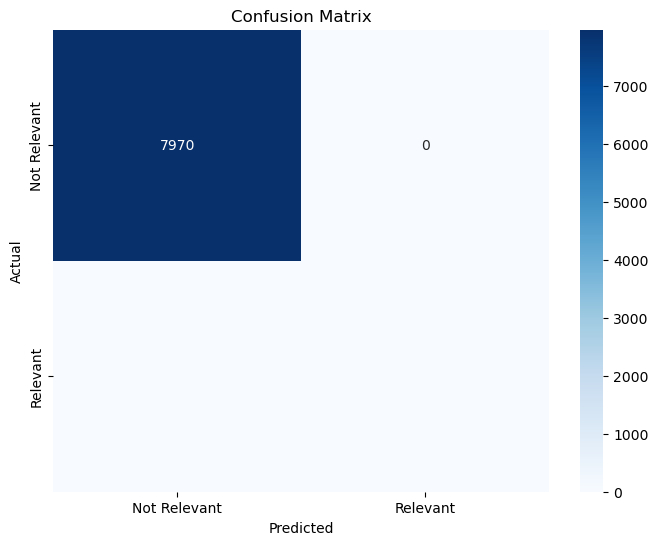

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7970
           1       0.00      0.00      0.00        30

    accuracy                           1.00      8000
   macro avg       0.50      0.50      0.50      8000
weighted avg       0.99      1.00      0.99      8000



In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report in a more readable format
print("Classification Report:")
print(class_report)